This notebook does some simple plotting of `cosz` against upwards and downwards SW fluxes. A linear coefficient `beta` is extracted between `cosz` and `fnet_dn_sw_h` at the top level (index=-1). This coefficient is then used to scale both `fnet_dn_sw_h` and `fnet_up_sw_h` in `preprocessing_sw_dynamical.py` and `preprocessing_sw_optical.py`.

In [2]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/ucaptp0/oasis-rt-surrogate")
from model.rnn_sw.preprocessing_sw_dynamical import DataProcesser

In [3]:
directory = "/home/ucaptp0/oasis-rt-surrogate/data/raw_data"
savepath = "/home/ucaptp0/oasis-rt-surrogate/data/constants"
timestep = 11
datapath = os.path.join(directory, "oasis_output_Venus_{}.h5".format(timestep))

# Load data
output = DataProcesser.extract_data(datapath)
output_400 = DataProcesser.extract_data(os.path.join(directory, "oasis_output_Venus_400.h5"))

## Short-wave Schema

In [4]:
# Extract cosz and sw fluxes
cosz = output["cosz"]
fnet_dn_sw_h = output["fnet_dn_sw_h"]
fnet_up_sw_h = output["fnet_up_sw_h"]

print("Shape of cosz: ", cosz.shape)
print("Shape of fnet_dn_sw_h: ", fnet_dn_sw_h.shape)
print("Shape of fnet_up_sw_h: ", fnet_up_sw_h.shape)

# Reshape flux data to cols x levels
ncol = 10242
nlev = 50
fnet_dn_sw_h = np.reshape(fnet_dn_sw_h, newshape=(ncol, nlev))
fnet_up_sw_h = np.reshape(fnet_up_sw_h, newshape=(ncol, nlev))

print("Shape of cosz: ", cosz.shape)
print("Shape of fnet_dn_sw_h: ", fnet_dn_sw_h.shape)
print("Shape of fnet_up_sw_h: ", fnet_up_sw_h.shape)

# Extract top layer fluxes
fnet_dn_sw_h_top = fnet_dn_sw_h[:, -1]
fnet_up_sw_h_top = fnet_up_sw_h[:, -1]

print("Shape of cosz: ", cosz.shape)
print("Shape of fnet_dn_sw_h_top: ", fnet_dn_sw_h_top.shape)
print("Shape of fnet_up_sw_h_top: ", fnet_up_sw_h_top.shape)

# Extract quantities for output_400
cosz_400 = output_400["cosz"]
fnet_dn_sw_h_400 = output_400["fnet_dn_sw_h"]
fnet_up_sw_h_400 = output_400["fnet_up_sw_h"]
fnet_dn_sw_h_400 = np.reshape(fnet_dn_sw_h_400, newshape=(ncol, nlev))
fnet_up_sw_h_400 = np.reshape(fnet_up_sw_h_400, newshape=(ncol, nlev))
fnet_dn_sw_h_top_400 = fnet_dn_sw_h_400[:, -1]
fnet_up_sw_h_top_400 = fnet_up_sw_h_400[:, -1]

Shape of cosz:  (10242,)
Shape of fnet_dn_sw_h:  (512100,)
Shape of fnet_up_sw_h:  (512100,)
Shape of cosz:  (10242,)
Shape of fnet_dn_sw_h:  (10242, 50)
Shape of fnet_up_sw_h:  (10242, 50)
Shape of cosz:  (10242,)
Shape of fnet_dn_sw_h_top:  (10242,)
Shape of fnet_up_sw_h_top:  (10242,)


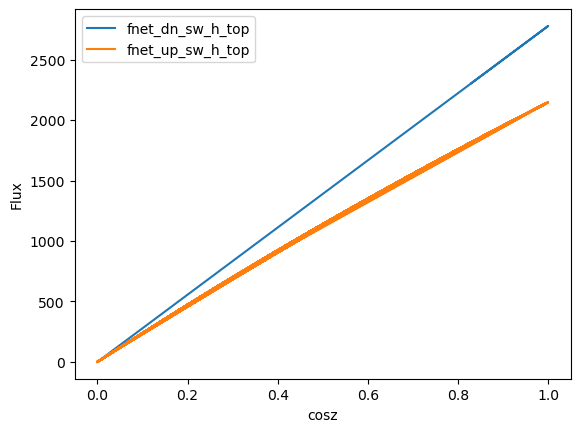

Coefficients of fit:  [2.77880599e+03 2.87579395e-13]


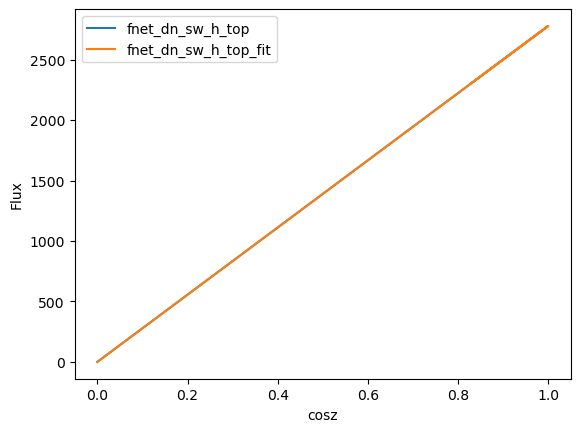

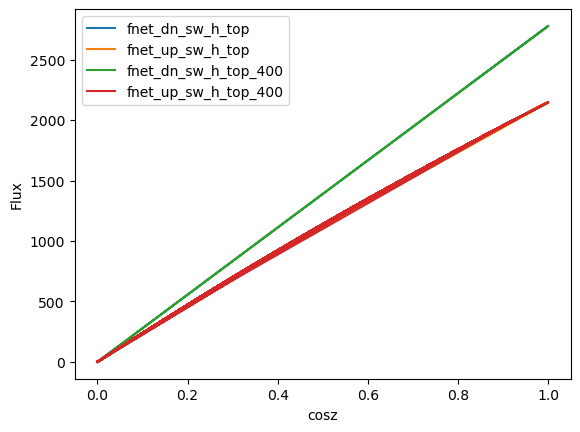

In [5]:
# Plot cosz vs. top layer fluxes
plt.figure()
plt.plot(cosz, fnet_dn_sw_h_top, label="fnet_dn_sw_h_top")
plt.plot(cosz, fnet_up_sw_h_top, label="fnet_up_sw_h_top")
plt.xlabel("cosz")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Fit a straight line to cosz vs fnet_dn_sw_h_top with no intercept
coeffs_sw = np.polyfit(cosz, fnet_dn_sw_h_top, 1)
print("Coefficients of fit: ", coeffs_sw)
fnet_dn_sw_h_top_fit = coeffs_sw[0] * cosz + coeffs_sw[1]
plt.figure()
plt.plot(cosz, fnet_dn_sw_h_top, label="fnet_dn_sw_h_top")
plt.plot(cosz, fnet_dn_sw_h_top_fit, label="fnet_dn_sw_h_top_fit")
plt.xlabel("cosz")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Plot cosz vs. top layer fluxes for output_400 and output
plt.figure()
plt.plot(cosz, fnet_dn_sw_h_top, label="fnet_dn_sw_h_top")
plt.plot(cosz, fnet_up_sw_h_top, label="fnet_up_sw_h_top")
plt.plot(cosz_400, fnet_dn_sw_h_top_400, label="fnet_dn_sw_h_top_400")
plt.plot(cosz_400, fnet_up_sw_h_top_400, label="fnet_up_sw_h_top_400")
plt.xlabel("cosz")
plt.ylabel("Flux")
plt.legend()
plt.show()

The last plot shows that the same trend persists across different timesteps, suggesting it is reasonable to use same `m` and `c` linear coefficients to map between `cosz` and scaling factors.

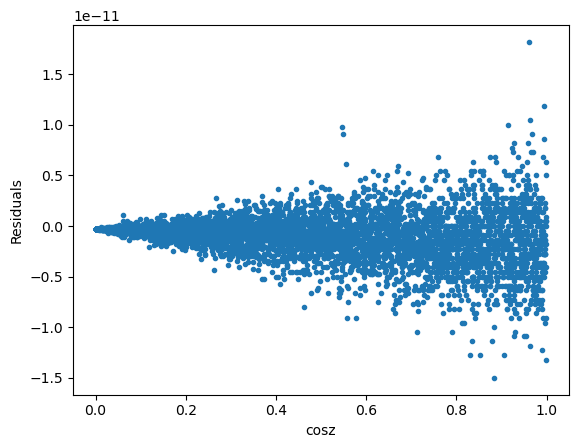

In [25]:
# Find the residuals as a scatter plot
residuals = fnet_dn_sw_h_top - fnet_dn_sw_h_top_fit
plt.figure()
plt.scatter(cosz, residuals, marker=".")
plt.xlabel("cosz")
plt.ylabel("Residuals")
plt.show()

In [26]:
def scaling(cosz, flux_up, flux_down, coeffs_sw):
    """
    Array shapes:
        cosz: (ncol,)
        flux_up: (ncol, nlev)
        flux_down: (ncol, nlev)
    """
    # Find indices where cosz==0
    idx = np.where(cosz == 0)
    
    # Remove columns from flux_up and flux_down where cosz==0
    flux_up = np.delete(flux_up, idx, axis=0)
    flux_down = np.delete(flux_down, idx, axis=0)
    cosz = np.delete(cosz, idx, axis=0)

    # Divide each column in flux_up by the corresponding cosz
    flux_up_scaled = flux_up / (coeffs_sw[0] * cosz[:, None] + coeffs_sw[1])
    flux_down_scaled = flux_down / (coeffs_sw[0] * cosz[:, None] + coeffs_sw[1])

    return cosz, flux_up_scaled, flux_down_scaled

cosz, fnet_up_sw_h_scaled, fnet_dn_sw_h_scaled = scaling(cosz, fnet_up_sw_h, fnet_dn_sw_h, coeffs_sw)

print("Shape of fnet_up_sw_h_scaled: ", fnet_up_sw_h_scaled.shape)
print("Shape of fnet_dn_sw_h_scaled: ", fnet_dn_sw_h_scaled.shape)

Shape of fnet_up_sw_h_scaled:  (5120, 50)
Shape of fnet_dn_sw_h_scaled:  (5120, 50)


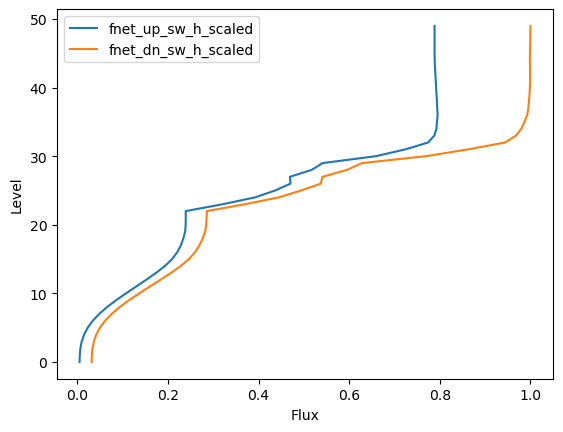

In [27]:
# For a given column, plot the scaled fluxes against the level
col = 0
plt.figure()
plt.plot(fnet_up_sw_h_scaled[col, :], range(nlev), label="fnet_up_sw_h_scaled")
plt.plot(fnet_dn_sw_h_scaled[col, :], range(nlev), label="fnet_dn_sw_h_scaled")
plt.xlabel("Flux")
plt.ylabel("Level")
plt.legend()
plt.show()

In [28]:
# Save coeffs_sw to txt file
np.savetxt(os.path.join(savepath, "sw_flux_scaling_factors.txt"), coeffs_sw)

## Long-wave Schema

In [5]:
# Extract flx_grd and sw fluxes
flx_grd = output["flx_grd"]
sTemperature = output["sTemperature"]
fnet_dn_lw_h = output["fnet_dn_lw_h"]
fnet_up_lw_h = output["fnet_up_lw_h"]

print("Shape of flx_grd: ", flx_grd.shape)
print("Shape of sTemperature: ", sTemperature.shape)
print("Shape of fnet_dn_lw_h: ", fnet_dn_lw_h.shape)
print("Shape of fnet_up_lw_h: ", fnet_up_lw_h.shape)

# Reshape flux data to cols x levels
ncol = 10242
nlev = 50
fnet_dn_lw_h = np.reshape(fnet_dn_lw_h, newshape=(ncol, nlev))
fnet_up_lw_h = np.reshape(fnet_up_lw_h, newshape=(ncol, nlev))

print("Shape of flx_grd: ", flx_grd.shape)
print("Shape of sTemperature: ", sTemperature.shape)
print("Shape of fnet_dn_lw_h: ", fnet_dn_lw_h.shape)
print("Shape of fnet_up_lw_h: ", fnet_up_lw_h.shape)

# Extract top layer fluxes
fnet_dn_lw_h_bottom = fnet_dn_lw_h[:, 0]
fnet_up_lw_h_bottom = fnet_up_lw_h[:, 0]

print("Shape of flx_grd: ", flx_grd.shape)
print("Shape of sTemperature: ", sTemperature.shape)
print("Shape of fnet_dn_lw_h_top: ", fnet_dn_lw_h_bottom.shape)
print("Shape of fnet_up_lw_h_top: ", fnet_up_lw_h_bottom.shape)

Shape of flx_grd:  (10242,)
Shape of sTemperature:  (10242,)
Shape of fnet_dn_lw_h:  (512100,)
Shape of fnet_up_lw_h:  (512100,)
Shape of flx_grd:  (10242,)
Shape of sTemperature:  (10242,)
Shape of fnet_dn_lw_h:  (10242, 50)
Shape of fnet_up_lw_h:  (10242, 50)
Shape of flx_grd:  (10242,)
Shape of sTemperature:  (10242,)
Shape of fnet_dn_lw_h_top:  (10242,)
Shape of fnet_up_lw_h_top:  (10242,)


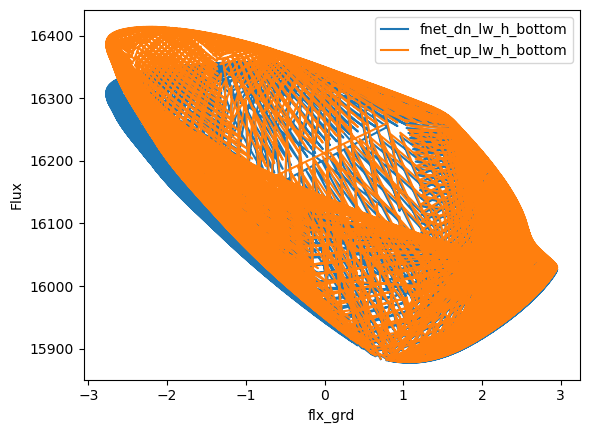

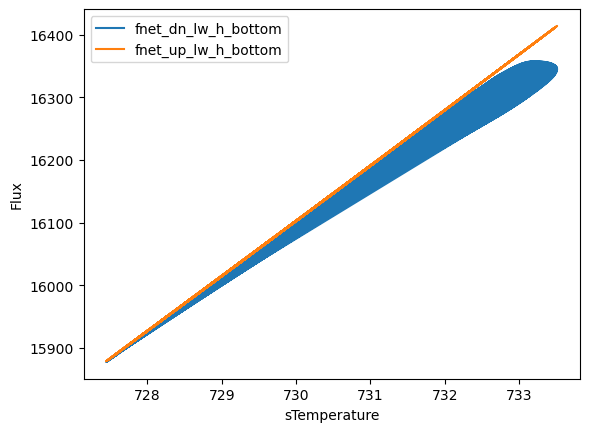

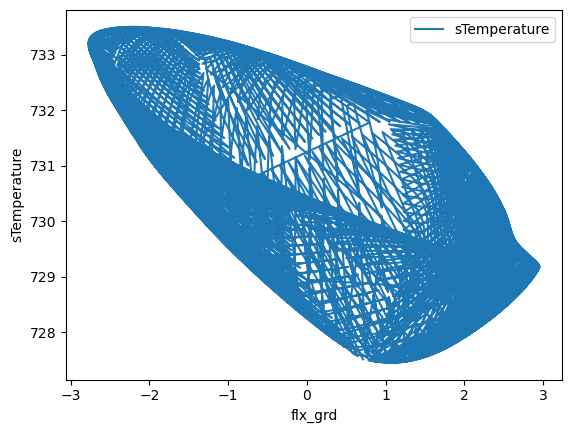

In [8]:
# Plot flx_grd vs. bottom layer fluxes
plt.figure()
plt.plot(flx_grd, fnet_dn_lw_h_bottom, label="fnet_dn_lw_h_bottom")
plt.plot(flx_grd, fnet_up_lw_h_bottom, label="fnet_up_lw_h_bottom")
plt.xlabel("flx_grd")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Plot sTemperature vs. bottom layer fluxes
plt.figure()
plt.plot(sTemperature, fnet_dn_lw_h_bottom, label="fnet_dn_lw_h_bottom")
plt.plot(sTemperature, fnet_up_lw_h_bottom, label="fnet_up_lw_h_bottom")
plt.xlabel("sTemperature")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Plot flx_grd vs sTemperature
plt.figure()
plt.plot(flx_grd, sTemperature, label="sTemperature")
plt.xlabel("flx_grd")
plt.ylabel("sTemperature")
plt.legend()
plt.show()

There is clearly a linear dependence of `fnet_up_lw_bottom` on `sTemperature`. We will find the gradient coefficient `m` of this linear dependence and use `m * sTemperature` as our scaling for upward and downward fluxes.

Coefficients of fit:  [    88.46453815 -48476.1685984 ]


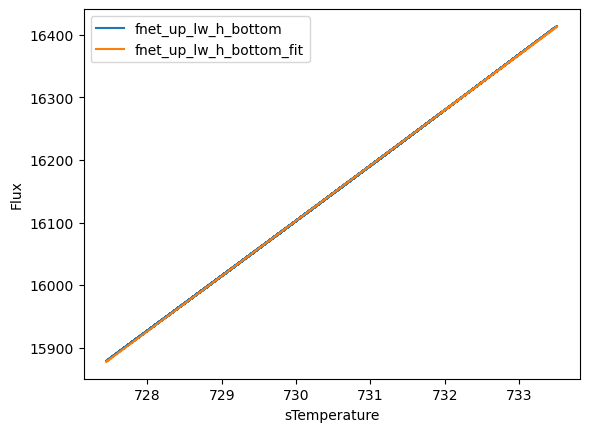

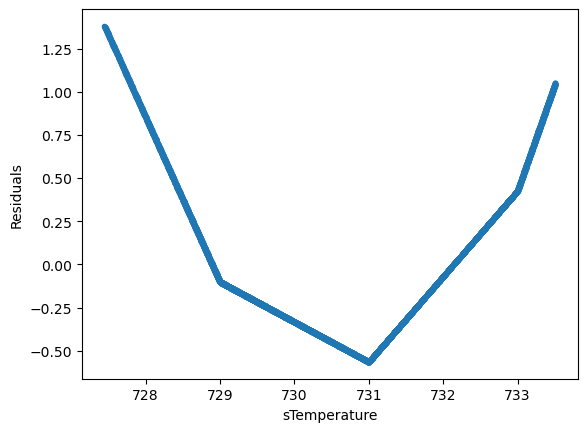

In [13]:
# Fit a straight line to sTemperature vs fnet_up_lw_h_bottom
coeffs_lw = np.polyfit(sTemperature, fnet_up_lw_h_bottom, 1)
print("Coefficients of fit: ", coeffs_lw)
fnet_up_lw_h_bottom_fit = coeffs_lw[0] * sTemperature + coeffs_lw[1]
plt.figure()
plt.plot(sTemperature, fnet_up_lw_h_bottom, label="fnet_up_lw_h_bottom")
plt.plot(sTemperature, fnet_up_lw_h_bottom_fit, label="fnet_up_lw_h_bottom_fit")
plt.xlabel("sTemperature")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Find the residuals as a scatter plot
residuals = fnet_up_lw_h_bottom - fnet_up_lw_h_bottom_fit
plt.figure()
plt.scatter(sTemperature, residuals, marker=".")
plt.xlabel("sTemperature")
plt.ylabel("Residuals")
plt.show()

In [16]:
def scaling_lw(sTemperature, flux_up, flux_down, coeffs_lw):
    """
    Array shapes:
        cosz: (ncol,)
        flux_up: (ncol, nlev)
        flux_down: (ncol, nlev)
    """

    # Divide each column in flux_up by the corresponding cosz
    flux_up_scaled = flux_up / (coeffs_lw[0] * sTemperature[:, None] + coeffs_lw[1])
    flux_down_scaled = flux_down / (coeffs_lw[0] * sTemperature[:, None] + coeffs_lw[1])

    return flux_up_scaled, flux_down_scaled

fnet_up_lw_h_scaled, fnet_dn_lw_h_scaled = scaling_lw(sTemperature, fnet_up_lw_h, fnet_dn_lw_h, coeffs_lw)

print("Shape of fnet_up_lw_h_scaled: ", fnet_up_lw_h_scaled.shape)
print("Shape of fnet_dn_lw_h_scaled: ", fnet_dn_lw_h_scaled.shape)

Shape of fnet_up_lw_h_scaled:  (10242, 50)
Shape of fnet_dn_lw_h_scaled:  (10242, 50)


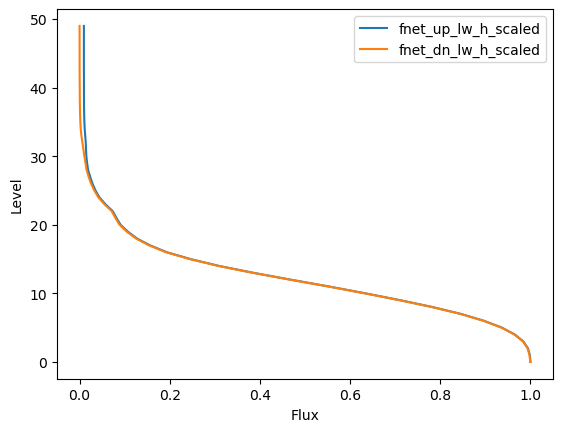

In [17]:
col = 3500

# For a given column, plot the scaled fluxes against the level
plt.figure()
plt.plot(fnet_up_lw_h_scaled[col, :], range(nlev), label="fnet_up_lw_h_scaled")
plt.plot(fnet_dn_lw_h_scaled[col, :], range(nlev), label="fnet_dn_lw_h_scaled")
plt.xlabel("Flux")
plt.ylabel("Level")
plt.legend()
plt.show()

In [20]:
# Save coeffs_lw to txt file
np.savetxt(os.path.join(savepath, "lw_flux_scaling_factors.txt"), coeffs_lw)